In [1]:
# %load_ext nb_black
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

spark = SparkSession.builder.getOrCreate()

In [2]:
spark

In [3]:
import os
from os.path import isfile, join

loc = os.path.abspath("")
data_loc = f"{loc}/creditcard.csv"

In [6]:
df = spark.read.csv(data_loc, inferSchema=True, header=True)

In [7]:
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [8]:
df = df.select('Time','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class')

### Train/test split

In [9]:
train, test = df.randomSplit([0.8, 0.2], seed=7)

In [10]:
print(f"Train set length: {train.count()} records")
print(f"Test set length: {test.count()} records")

Train set length: 227822 records
Test set length: 56985 records


### Vector assembling

VectorAssembler:
Combines the values of input columns into a single vector.
http://spark.apache.org/docs/latest/ml-features#vectorassembler


In [11]:
from pyspark.ml.feature import VectorAssembler

In [12]:
columns = [x for x in df.columns if x != 'Class']

In [13]:
columns

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

In [14]:
vector_assembler = VectorAssembler(
    inputCols=columns, outputCol="features"
)

### Logistic Regression

In [21]:
%%time
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

pipeline = Pipeline(stages=[vector_assembler])
modelLR = pipeline.fit(train)

predictionsLR = modelLR.transform(test)

Wall time: 56.8 ms


In [22]:
predictionsLR.select(
    'features',
).show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [23]:
data = predictionsLR.select("features","Class")

In [24]:
data.show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [26]:
%%time
data = data.withColumnRenamed('Class','label')

modelLR = LogisticRegression().fit(data)

Wall time: 12.1 s


In [27]:
modelLR.summary.areaUnderROC

0.9748117865503284

In [59]:
accuracyLR = modelLR.summary.accuracy
accuracyLR

0.9993682548038958

In [65]:
modelLR.summary.weightedPrecision

0.99933688957913

In [30]:
modelLR.summary.recallByLabel

[0.9998945166224222, 0.7115384615384616]

In [ ]:
modelLR.summary.

In [31]:
modelLR.summary.pr.show()

+------------------+--------------------+
|            recall|           precision|
+------------------+--------------------+
|               0.0| 0.16230366492146597|
|0.8942307692307693| 0.16230366492146597|
|0.8942307692307693| 0.08136482939632546|
|0.9134615384615384|0.055490654205607476|
|0.9230769230769231| 0.04208680403331872|
|0.9230769230769231|  0.0336723956506489|
|0.9230769230769231|0.028061970184156678|
|0.9230769230769231| 0.02405412177399148|
|0.9230769230769231| 0.02104340201665936|
|0.9230769230769231|0.018702513150204558|
|0.9230769230769231| 0.01683619782532445|
|0.9230769230769231|0.015308563227555414|
|0.9326923076923077|0.014338507021433852|
|0.9326923076923077| 0.01322607035724025|
|0.9423076923076923|0.012395648874272705|
|0.9423076923076923|0.011563421828908554|
|0.9423076923076923|0.010834715312327253|
|0.9423076923076923| 0.01019134775374376|
|0.9423076923076923|0.009621048497938347|
|0.9423076923076923|0.009112040911204091|
+------------------+--------------

### Decision Tree

In [32]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [36]:
%%time
DT = DecisionTreeClassifier(labelCol="Class", featuresCol="features")

Wall time: 4.99 ms


In [37]:
pipelineDT = Pipeline(stages=[vector_assembler, DT])

In [38]:
modelDT = pipelineDT.fit(train)

In [39]:
predictionsDT = modelDT.transform(test)

In [40]:
predictionsDT.select("prediction", "Class", "features").show(5)


+----------+-----+--------------------+
|prediction|Class|            features|
+----------+-----+--------------------+
|       0.0|    0|[2.0,-0.425965884...|
|       0.0|    0|[7.0,-0.894286082...|
|       0.0|    0|[9.0,-0.338261752...|
|       0.0|    0|[10.0,0.384978215...|
|       0.0|    0|[12.0,-2.79185476...|
+----------+-----+--------------------+
only showing top 5 rows



In [41]:
evaluatorDT = MulticlassClassificationEvaluator(
    labelCol="Class", predictionCol="prediction", metricName="accuracy")
accuracyDT = evaluatorDT.evaluate(predictionsDT)
print("Accuracy = %g " % (accuracyDT))



Accuracy = 0.999368 


### Random Forest

In [42]:
from pyspark.ml.classification import RandomForestClassifier

In [43]:
%%time
RF = RandomForestClassifier(labelCol="Class", featuresCol="features", numTrees=10)

Wall time: 19.9 ms


In [44]:
pipelineRF = Pipeline(stages=[vector_assembler, RF])

In [45]:
modelRF = pipelineRF.fit(train)

In [46]:
predictionsRF = modelRF.transform(test)

In [47]:
predictionsRF.select("prediction", "Class", "features").show(5)


+----------+-----+--------------------+
|prediction|Class|            features|
+----------+-----+--------------------+
|       0.0|    0|[2.0,-0.425965884...|
|       0.0|    0|[7.0,-0.894286082...|
|       0.0|    0|[9.0,-0.338261752...|
|       0.0|    0|[10.0,0.384978215...|
|       0.0|    0|[12.0,-2.79185476...|
+----------+-----+--------------------+
only showing top 5 rows



In [48]:
evaluatorRF = MulticlassClassificationEvaluator(
    labelCol="Class", predictionCol="prediction", metricName="accuracy")
accuracyRF = evaluatorRF.evaluate(predictionsRF)
print("Accuracy = %g " % (accuracyRF))



Accuracy = 0.999386 


### Gradient-Boosted

In [49]:
from pyspark.ml.classification import GBTClassifier

In [51]:
%%time
GB = GBTClassifier(labelCol="Class", featuresCol="features", maxIter=10)

Wall time: 7.97 ms


In [52]:
pipelineGB = Pipeline(stages=[vector_assembler, GB])

In [53]:
modelGB = pipelineGB.fit(train)

In [54]:
predictionsGB = modelGB.transform(test)

In [55]:
predictionsGB.select("prediction", "Class", "features").show(5)


+----------+-----+--------------------+
|prediction|Class|            features|
+----------+-----+--------------------+
|       0.0|    0|[2.0,-0.425965884...|
|       0.0|    0|[7.0,-0.894286082...|
|       0.0|    0|[9.0,-0.338261752...|
|       0.0|    0|[10.0,0.384978215...|
|       0.0|    0|[12.0,-2.79185476...|
+----------+-----+--------------------+
only showing top 5 rows



In [56]:
evaluatorGB = MulticlassClassificationEvaluator(
    labelCol="Class", predictionCol="prediction", metricName="accuracy")
accuracyGB = evaluatorGB.evaluate(predictionsGB)
print("Accuracy = %g " % (accuracyGB))



Accuracy = 0.999438 


In [62]:
import pandas as pd

models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient-Boosted']
accuracies = [accuracyLR, accuracyDT, accuracyRF, accuracyGB]
model_scores = pd.DataFrame(data=list(zip(models,accuracies)), columns=['model','score'])
model_scores

,model,score
0,Logistic Regression,0.999368
1,Decision Tree,0.999368
2,Random Forest,0.999386
3,Gradient-Boosted,0.999438


(0.999, 1)

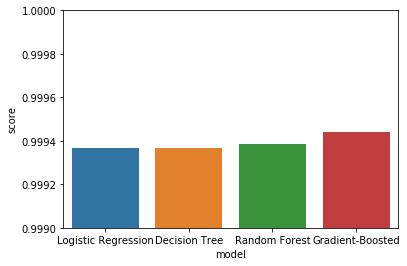

In [69]:
import seaborn as sns
ax = sns.barplot(x="model", y="score", data=model_scores)
ax.set_ylim(0.999, 1)
